In [1]:
%matplotlib notebook
import numpy as np
MEPS = np.finfo(float).eps
import scipy.linalg as la
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, lsqr

from numpy.linalg import cond, norm, inv


import pandas as pd

import pickle
import os.path

import warnings
warnings.simplefilter('ignore')

from scipy.optimize import minimize_scalar

from poly_basis import *
from spherepts import *
from rbf import *

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [31]:
def dist_outer(nodes1, nodes2, W):
    ret = [ [(n1-n2) @ W @ (n1-n2) for n1 in nodes1] for n2 in nodes2]
    return np.sqrt(ret)

In [32]:
# Choose RBF
rbf_obj = rbf_dict['gaussian']
rbf = rbf_obj['rbf']
zeta  = rbf_obj['zeta']
d2rbf = rbf_obj['d2rbf']
Lrbf = lambda r,eps: 2*zeta(r,eps) + d2rbf(r,eps)

# Choose solution and forcing fuction
solution_index = 5
sol_deg = sphere_harm_degs[solution_index]
foo = lambda x: sphere_harm[solution_index](*x)*sol_deg*(sol_deg+1)
exact = lambda x: sphere_harm[solution_index](*x)
print('Harmonic degree: %d' % sol_deg)

Harmonic degree: 2


In [47]:
n = 200
eps = .5
k = 20
my_node = n//7

nodes = gen_spiral_nodes(n)
Ws = np.zeros((n, 3, 3))
Rs = np.zeros((n, 3, 3))
e1, e2, e3 = np.eye(3)
E = np.eye(3)
E[2,2] = 0
for i, node in enumerate(nodes):
    t1 = e2 - np.dot(node, e2)*node
    t1 /= la.norm(t1)
    t2 = e3 - np.dot(node, e3)*node - np.dot(t1, e3)*t1
    t2 /= la.norm(t2)
    Rs[i,:,0] = t1
    Rs[i,:,1] = t2
    Rs[i,:,2] = node
    Ws[i] = Rs[i].T @ E @ Rs[i]
    
W = Ws[my_node]
R = Rs[my_node]
tree = cKDTree(np.array(nodes))
stencil = tree.query(nodes[my_node], k)[1]
nn = np.array([nodes[i] for i in stencil]) #nodes in the stencil

<IPython.core.display.Javascript object>


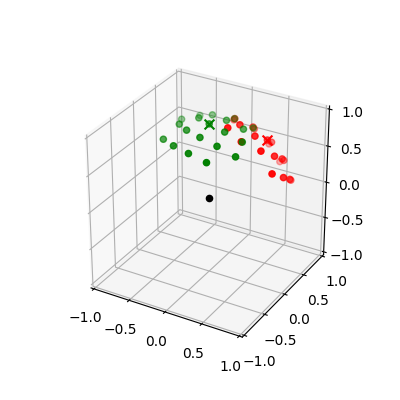

In [48]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

rn = nn @ Rs[my_node]

ax.scatter(nn[:,0], nn[:,1], nn[:,2], '.', color='r')
ax.scatter(rn[:,0], rn[:,1], rn[:,2], '.', color='g')
ax.scatter(nn[0,0], nn[0,1], nn[0,2], '.', color='r', s=[50], marker='x')
ax.scatter(rn[0,0], rn[0,1], rn[0,2], '.', color='g', s=[50], marker='x')
ax.scatter(0, 0, 0, '.', color='k')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

plt.show()

In [45]:
nodes[my_node]@ Rs[my_node]

array([-2.77555756e-17,  5.55111512e-17,  1.00000000e+00])

# Tangent Plane Method

In [49]:


A = rbf(dist_outer(nn, nn, W), eps)
print('cond(A) = %g\n' % la.cond(A))
rhs = Lrbf(dist_outer(nn[0].reshape((1,3)), nn, W), eps)
ws = la.solve(A, rhs.flatten())

L_approx = np.dot(ws, [foo(node) for node in nn])
L_actual = exact(nn[0])

print('Approximated Laplacian = %g' % L_approx)
print('Actual Laplacian = %g\n' %L_actual)
print('Relative error = %g' % np.abs((L_approx - L_actual)/L_actual))

cond(A) = 5.40344e+11

Approximated Laplacian = -30.6288
Actual Laplacian = 0.328136

Relative error = 94.3417


In [37]:
ws

array([-163.99805284,   24.22199886,   17.01938944,   54.00069877,
         55.57455677,   41.53860563,    4.82404217,   -1.97805562,
         -6.67523453,  -10.83898961,    3.71577161,   -3.29582919,
         -1.11028075,   -2.05113188,   -7.809908  ,   -7.76252764,
          0.94977638,   -1.50689402,    0.42610244,    4.25591825])

In [38]:
my_dist = dist_outer(nn,nn,W)
proj_nodes = (nn @ R)[:,:2]
proj_dist = dist_outer(proj_nodes, proj_nodes, np.eye(2))

In [39]:
proj_dist - my_dist

array([[ 0.00000000e+00,  1.34973227e-03, -1.83562679e-03,
         7.76669355e-02,  1.30196598e-01,  9.13758484e-02,
         6.26644968e-02,  2.24750808e-02,  6.41802301e-02,
         2.53626001e-02, -5.38761185e-03,  8.56719830e-02,
         3.16264354e-01, -2.12212511e-03,  2.23020458e-01,
         2.65535842e-01, -1.96269515e-02, -1.60103765e-02,
         8.58937549e-02,  1.11762580e-01],
       [ 1.34973227e-03,  0.00000000e+00,  1.99814665e-03,
         3.83776006e-02,  9.42927274e-02,  1.28504000e-01,
         5.60815391e-02,  9.40263076e-03,  7.05613731e-02,
         8.73465216e-02, -9.81608033e-03,  5.84060545e-02,
         2.82625780e-01,  1.09318420e-02,  3.06168050e-01,
         2.16164088e-01, -1.14018432e-02,  8.78646251e-04,
         7.81078332e-02,  2.11156567e-01],
       [-1.83562679e-03,  1.99814665e-03,  0.00000000e+00,
         6.18482769e-02,  9.50097868e-02,  4.69162085e-02,
         1.22128451e-01,  5.44326442e-02,  5.14593618e-02,
         1.75622826e-02,  1.3